## まとめ
* パラメータの更新方法にはSGDの他に、有名なものとして、MomentumやAdaGrad、Adamなどの手法がある
* 重みの初期値の与え方は、正しい学習を行う上で非常に重要である
* 重みの初期値として「Xavierの初期値」や「Heの初期値」が有効である
* Batch Normalizationを用いることで、学習を速くすすめる事ができ、また、初期値に対してロバストになる
* 過学習を抑制するための正則化の技術として、Weight DecayやDropoutがある
* ハイパーパラメータの探索は、良い値が存在する範囲を徐々に絞りながらすすめるのが効率の良い方法である

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import sys,os
ROOT_PATH='/content/drive/My Drive/Colab Notebooks/zero_DL/deep-learning-from-scratch/'
sys.path.append(ROOT_PATH)
sys.path.append(os.pardir)

In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

## パラメータの更新
https://qiita.com/omiita/items/1735c1d048fe5f611f80

### SGD
$$
\theta \leftarrow \theta - \eta g\\
$$

In [ ]:
class SGD:
  def __init__(self,lr=0.01):
    self.lr=lr

  def update(self,params,grads):
    for key in params.keys():
      params[key]-=self.lr*grads[key]

    return params

### Momentum
$$
v \leftarrow \alpha v - \eta g\\
\theta \leftarrow \theta + v\\
(\alpha: \mathrm{Momentum} \fallingdotseq 0.9)\\
$$

* パラメータが更新される方向にさらに加速させる

In [ ]:
class Momentum:
  def __init__(self,lr=0.01,momentum=0.9):
    self.lr=lr
    self.momentum=momentum
    self.v=None #vをメンバ変数に保持

  def update(self,params,grads):
    if self.v is None:
      self.v={}
      for key,val in params.items():    #params[key]のvalueと同じ形状の0行列をv[key]に代入
        self.v[key]=np.zeros_like(val)
    
    for key in params.keys():
      self.v[key]=self.v[key]*self.momentum-self.lr*grads[key]  #最初のvは0*(Momentum)-(学習率)*(勾配)=(学習率)*(勾配)
      params[key]+=self.v[key]

    return params

### NesterovのMomentum

$$
\begin{eqnarray}
v_{t+1} &\leftarrow& \alpha v_t - \eta g\\
\theta_{t+1} &\leftarrow& \theta_t + \alpha (\alpha v_{t+1} - \eta g) - \eta g\\
(\alpha &:& \mathrm{Momentum} \fallingdotseq 0.9)
\end{eqnarray}
$$

* 誤差関数に対して勾配降下した先の勾配（近似）を現在の勾配として使用することで、最適値を通り過ぎた場合にブレーキがかかるような動きをする

In [ ]:
class Nesterov:

  """Nesterov's Accelerated Gradient (http://arxiv.org/abs/1212.0901)"""

  def __init__(self, lr=0.01, momentum=0.9):
    self.lr = lr
    self.momentum = momentum
    self.v = None
      
  def update(self, params, grads):
    if self.v is None:
      self.v = {}
      for key, val in params.items():
        self.v[key] = np.zeros_like(val)
      
    for key in params.keys():
      self.v[key] *= self.momentum  #αv
      self.v[key] -= self.lr * grads[key]   #αv-ηg
      params[key] += self.momentum * self.momentum * self.v[key]    #θ+α*α*(αv-ηg)
      params[key] -= (1 + self.momentum) * self.lr * grads[key] #θ+α*α*(αv-ηg)-(1+α)*ηg

    return params

### AdaGrad
$$
h \leftarrow h + g\odot g\\
\theta \leftarrow \theta - \eta \dfrac{1}{\sqrt{h}+\epsilon}g\\
$$  

* 勾配の2乗の平方根すなわち勾配の大きさで学習率を割る（勾配の大きかったパラメータの学習率を小さくする）
* $\epsilon$はゼロ除算回避用の小さい値(=1e-7)
* 学習を進めれば進めるほど学習率が小さくなるため、最終的にはパラメータが全く更新されなくなる

In [ ]:
class AdaGrad:
  def __init__(self,lr=0.01):
    self.lr=lr
    self.h=None

  def update(self,params,grads):
    if self.h is None:
      self.h={}
      for key,val in params.items():
        self.h[key]=np.zeros_like(val)
    for key in params.keys():
      self.h[key]+=grads[key]*grads[key]    #行列のアダマール積（要素ごとの積）
      params[key]-=self.lr*grads[key]/(np.sqrt(self.h[key])+1e-7)

    return params

### RMSprop
$$  
v \leftarrow \rho v+(1-\rho)g\odot g\\
\theta \leftarrow \theta - \eta  \dfrac{1}{\sqrt{v} + \epsilon}g\\
(\rho： \mathrm{decay} \mathrm{rate} \fallingdotseq 0.99)\\
$$  

* AdaGradの弱点である「パラメータが全く更新されなくなる」ことに対する対策を施したオプティマイザ
* AdaGradは学習率が小さくなる一方だったが、RMSpropでは減衰率(decay rate)をかけることで過去の勾配の大きさを徐々に忘れることができる
* すなわち、学習率が小さくなってきても、また大きくなることができる（学習率が復活する）

In [ ]:
class RMSprop:
  def __init__(self,lr=0.01,decay_rate=0.99):
    self.lr=lr
    self.decay_rate=decay_rate
    self.v=None

  def update(self,params,grads):
    if self.v is None:
      self.v={}
      for key,val in params.items():
        self.v[key]=np.zeros_like(val)
    
    for key in grads.keys():
      self.v[key]=self.decay_rate*self.v[key]+(1.-self.decay_rate)*grads[key]*grads[key]
      params[key]-=self.lr*(1./(np.sqrt(self.v[key])+1e-7))*grads[key]

    return params

### Adam

$$
\begin{eqnarray*} 
t&\leftarrow&t+1\\
m_t &\leftarrow& \beta_1 m_{t-1} + (1 - \beta_1) g \\ 
v_t &\leftarrow& \beta_2 v_{t-1} + (1 - \beta_2) g\odot g  \\
\eta_t &\leftarrow& \eta_{t-1} \dfrac{\sqrt{1-\beta_2^t}}{1-\beta_1^t}\\
\theta_t & \leftarrow & \theta_{t-1} - \eta_t \frac{m_t}{\sqrt{v_t} + \epsilon}\\
\end{eqnarray*}
$$

* AdamはRMSpropとAdaGradを融合したような手法
* 勾配の平均と分散を考慮してmomentを推定する

In [ ]:
class Adam:

    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
        
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        
        self.iter += 1
        lr_t  = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)  #学習率を更新する
        
        for key in params.keys():
            #self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]
            #self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])
            
            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)
            
            #unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            #unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            #params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

        return params

### 最適化手法ごとの比較

In [ ]:
#2層のニューラルネットにおける最適化方法の比較
from ch05.two_layer_net import TwoLayerNet
from common.layers import *
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

train_size=x_train.shape[0]
iters_num=10000
batch_size=100
lr=0.01
iter_per_epoch=max(train_size/batch_size,1)

optimizer_dict={'sgd':SGD,'momentum':Momentum,'adagrad':AdaGrad,'nesterov':Nesterov,
                'rmsprop':RMSprop,'adam':Adam}
network_dict={}
result={}

for key1 in optimizer_dict.keys():
  network_dict[key1]=TwoLayerNet(input_size=784,hidden_size=50,output_size=10)
  result[key1]={}
  for key2 in ('train_acc','test_acc','train_loss'):
    result[key1][key2]=[]

for i in range(iters_num):

  batch_mask=np.random.choice(train_size,batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  for key in optimizer_dict.keys():
    grads=network_dict[key].gradient(x_batch,t_batch)
    network_dict[key].params=optimizer_dict[key](lr).update(network_dict[key].params,grads)
    loss=network_dict[key].loss(x_batch,t_batch)
    result[key]['train_loss'].append(loss)

  if i % iter_per_epoch==0:
    print('epoch=',int(i/iter_per_epoch))
    for key in optimizer_dict.keys():
      train_acc=network_dict[key].accuracy(x_batch,t_batch)
      test_acc=network_dict[key].accuracy(x_test,t_test)

      result[key]['train_acc'].append(train_acc)
      result[key]['test_acc'].append(test_acc)

      print('train_acc('+str(key)+'):'+str(train_acc)+\
            ' test_acc('+str(key)+'):'+str(test_acc))

epoch= 0
train_acc(sgd):0.11 test_acc(sgd):0.1455
train_acc(momentum):0.17 test_acc(momentum):0.1011
train_acc(adagrad):0.2 test_acc(adagrad):0.1146
train_acc(nesterov):0.13 test_acc(nesterov):0.0979
train_acc(rmsprop):0.3 test_acc(rmsprop):0.1946
train_acc(adam):0.23 test_acc(adam):0.1426
epoch= 1
train_acc(sgd):0.56 test_acc(sgd):0.5512
train_acc(momentum):0.49 test_acc(momentum):0.4827
train_acc(adagrad):0.95 test_acc(adagrad):0.929
train_acc(nesterov):0.84 test_acc(nesterov):0.8362
train_acc(rmsprop):0.91 test_acc(rmsprop):0.8403
train_acc(adam):0.98 test_acc(adam):0.9307
epoch= 2
train_acc(sgd):0.79 test_acc(sgd):0.8002
train_acc(momentum):0.77 test_acc(momentum):0.7882
train_acc(adagrad):0.96 test_acc(adagrad):0.9417
train_acc(nesterov):0.85 test_acc(nesterov):0.8892
train_acc(rmsprop):0.85 test_acc(rmsprop):0.8668
train_acc(adam):0.99 test_acc(adam):0.9482
epoch= 3
train_acc(sgd):0.9 test_acc(sgd):0.8571
train_acc(momentum):0.87 test_acc(momentum):0.8489
train_acc(adagrad):1.0 t

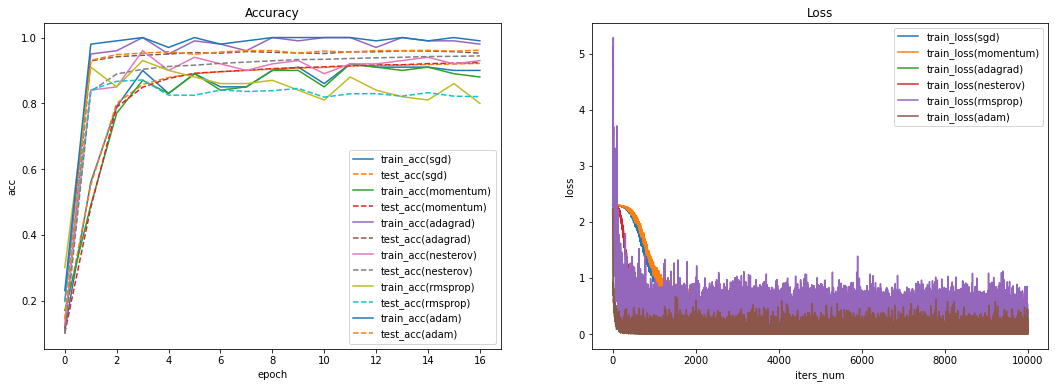

In [ ]:
#グラフ描画用
epoch=np.arange(iters_num/iter_per_epoch)
iters=np.arange(iters_num)

fig=plt.figure(figsize=(18,6),facecolor='w')
ax=fig.add_subplot('121')

for key in result.keys():
  ax.plot(epoch,result[key]['train_acc'],label='train_acc('+str(key)+')')
  ax.plot(epoch,result[key]['test_acc'],label='test_acc('+str(key)+')',linestyle='--')

ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.set_title('Accuracy')
plt.legend(loc='lower right')

ax=fig.add_subplot('122')
for key in result.keys():
  ax.plot(iters,result[key]['train_loss'],label='train_loss('+str(key)+')')

ax.set_xlabel('iters_num')
ax.set_ylabel('loss')
ax.set_title('Loss')
plt.legend(loc='upper right')
plt.show()

In [ ]:
#多層ニューラルネットにおける最適化方法の比較
from common.layers import *
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

train_size=x_train.shape[0]
iters_num=10000
batch_size=100
lr=0.01
iter_per_epoch=max(train_size/batch_size,1)

optimizer_dict={'sgd':SGD,'momentum':Momentum,'adagrad':AdaGrad,'nesterov':Nesterov,
                'rmsprop':RMSprop,'adam':Adam}
network_dict={}
result={}

for key1 in optimizer_dict.keys():
  network_dict[key1]=MultiLayerNet3(input_size=784,hidden_size_list=[100,100,100,100],
                                    output_size=10)
  result[key1]={}
  for key2 in ('train_acc','test_acc','train_loss'):
    result[key1][key2]=[]

for i in range(iters_num):

  batch_mask=np.random.choice(train_size,batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  for key in optimizer_dict.keys():
    grads=network_dict[key].gradient(x_batch,t_batch)
    network_dict[key].params=optimizer_dict[key](lr).update(network_dict[key].params,grads)
    loss=network_dict[key].loss(x_batch,t_batch)
    result[key]['train_loss'].append(loss)

  if i % iter_per_epoch==0:
    print('epoch=',int(i/iter_per_epoch))
    for key in optimizer_dict.keys():
      train_acc=network_dict[key].accuracy(x_batch,t_batch)
      test_acc=network_dict[key].accuracy(x_test,t_test)

      result[key]['train_acc'].append(train_acc)
      result[key]['test_acc'].append(test_acc)

      print('train_acc('+str(key)+'):'+str(train_acc)+\
            ' test_acc('+str(key)+'):'+str(test_acc))

epoch= 0
train_acc(sgd):0.05 test_acc(sgd):0.0592
train_acc(momentum):0.16 test_acc(momentum):0.1324
train_acc(adagrad):0.26 test_acc(adagrad):0.1827
train_acc(nesterov):0.13 test_acc(nesterov):0.0947
train_acc(rmsprop):0.15 test_acc(rmsprop):0.1009
train_acc(adam):0.34 test_acc(adam):0.1874
epoch= 1
train_acc(sgd):0.89 test_acc(sgd):0.894
train_acc(momentum):0.92 test_acc(momentum):0.8946
train_acc(adagrad):0.93 test_acc(adagrad):0.9172
train_acc(nesterov):0.94 test_acc(nesterov):0.9255
train_acc(rmsprop):0.34 test_acc(rmsprop):0.3563
train_acc(adam):0.83 test_acc(adam):0.8698
epoch= 2
train_acc(sgd):0.93 test_acc(sgd):0.9158
train_acc(momentum):0.92 test_acc(momentum):0.9156
train_acc(adagrad):0.95 test_acc(adagrad):0.8956
train_acc(nesterov):0.96 test_acc(nesterov):0.9411
train_acc(rmsprop):0.3 test_acc(rmsprop):0.2704
train_acc(adam):0.85 test_acc(adam):0.8631
epoch= 3
train_acc(sgd):0.95 test_acc(sgd):0.9285
train_acc(momentum):0.96 test_acc(momentum):0.9293
train_acc(adagrad):0.9

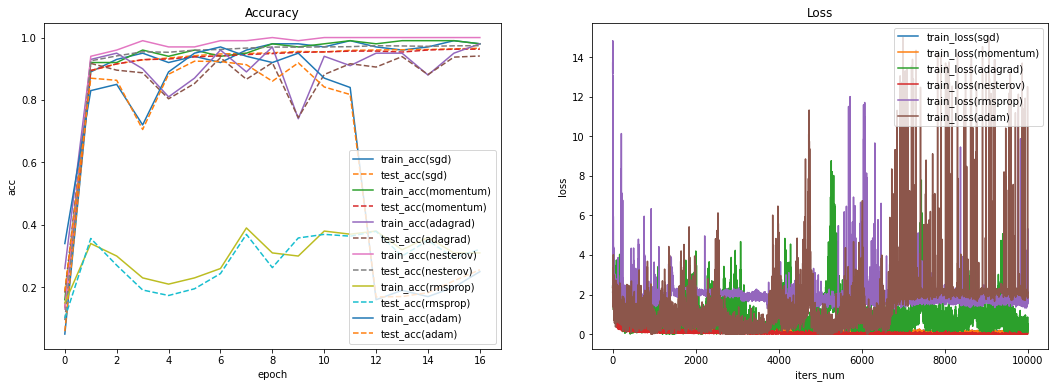

In [ ]:
epoch=np.arange(iters_num/iter_per_epoch)
iters=np.arange(iters_num)

fig=plt.figure(figsize=(18,6),facecolor='w')
ax=fig.add_subplot('121')

for key in result.keys():
  ax.plot(epoch,result[key]['train_acc'],label='train_acc('+str(key)+')')
  ax.plot(epoch,result[key]['test_acc'],label='test_acc('+str(key)+')',linestyle='--')

ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.set_title('Accuracy')
plt.legend(loc='lower right')

ax=fig.add_subplot('122')
for key in result.keys():
  ax.plot(iters,result[key]['train_loss'],label='train_loss('+str(key)+')')

ax.set_xlabel('iters_num')
ax.set_ylabel('loss')
ax.set_title('Loss')
plt.legend(loc='upper right')
plt.show()

## 重みの初期値による隠れ層のアクティベーション分布

### Sigmoid関数＋Xavierの初期値

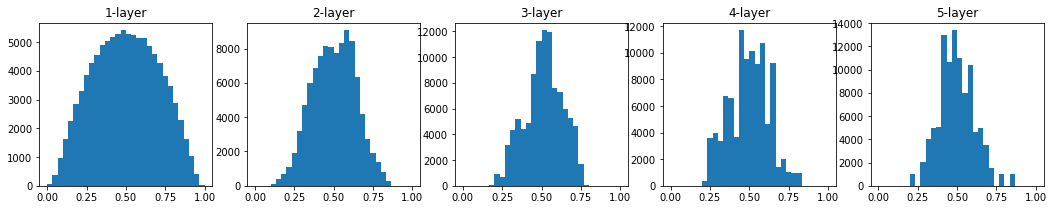

In [ ]:
x=np.random.randn(1000,100)

def sigmoid(x):
  return 1/(1+np.exp(-x))

node_num=100
hidden_layer_size=5
activations={}

for i in range(hidden_layer_size):
  if i != 0:
    x=activations[i-1]
  w=np.random.randn(node_num,node_num)/np.sqrt(node_num)    #Xavierの初期値
  z=np.dot(x,w)
  a=sigmoid(z)
  activations[i]=a

plt.figure(figsize=(18,3),facecolor='w')

for i ,a in activations.items():
  plt.subplot(1,len(activations),i+1)
  plt.title(str(i+1)+'-layer')
  plt.hist(a.flatten(),30,range=(0,1))
plt.show()

### ReLU関数＋Heの初期値

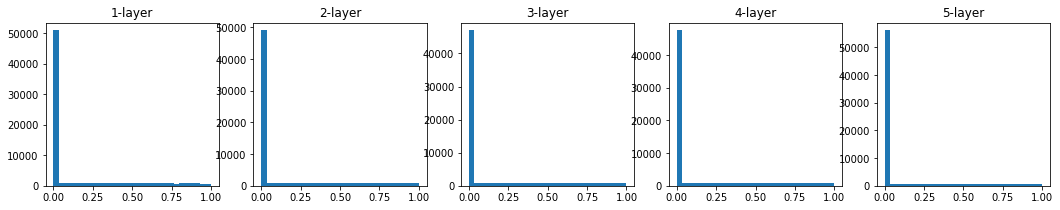

In [ ]:
x=np.random.randn(1000,100)

def relu(x):
  return np.maximum(x,0)

node_num=100
hidden_layer_size=5
activations={}

for i in range(hidden_layer_size):
  if i != 0:
    x=activations[i-1]
  #w=np.random.randn(node_num,node_num)*1
  w=np.random.randn(node_num,node_num)*(np.sqrt(2.0/node_num))   #Heの初期値
  z=np.dot(x,w)
  a=relu(z)
  activations[i]=a

plt.figure(figsize=(18,3),facecolor='w')

for i ,a in activations.items():
  plt.subplot(1,len(activations),i+1)
  plt.title(str(i+1)+'-layer')
  plt.hist(a.flatten(),30,range=(0,1))
plt.show()

### Sigmoid関数＋Heの初期値

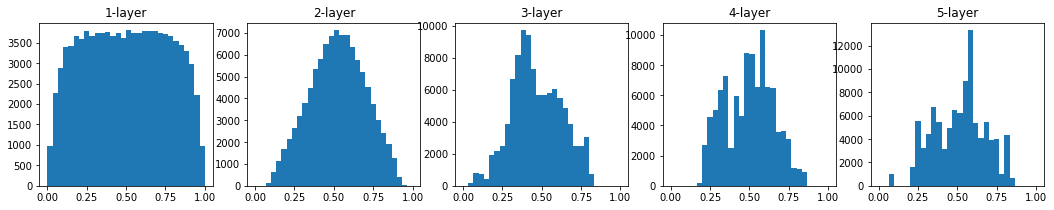

In [ ]:
x=np.random.randn(1000,100)

node_num=100
hidden_layer_size=5
activations={}

for i in range(hidden_layer_size):
  if i != 0:
    x=activations[i-1]
  w=np.random.randn(node_num,node_num)*(np.sqrt(2.0/node_num))   #Heの初期値
  z=np.dot(x,w)
  a=sigmoid(z)
  activations[i]=a

plt.figure(figsize=(18,3),facecolor='w')

for i ,a in activations.items():
  plt.subplot(1,len(activations),i+1)
  plt.title(str(i+1)+'-layer')
  plt.hist(a.flatten(),30,range=(0,1))
plt.show()

### ReLU関数＋偏差0.01のガウス分布

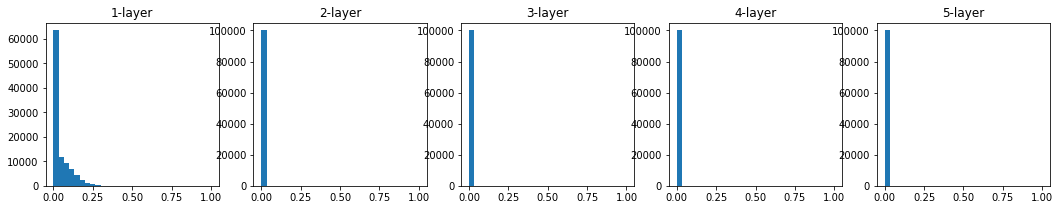

In [ ]:
x=np.random.randn(1000,100)

node_num=100
hidden_layer_size=5
activations={}

for i in range(hidden_layer_size):
  if i != 0:
    x=activations[i-1]
  w=np.random.randn(node_num,node_num)*0.01
  z=np.dot(x,w)
  a=relu(z)
  activations[i]=a

plt.figure(figsize=(18,3),facecolor='w')

for i ,a in activations.items():
  plt.subplot(1,len(activations),i+1)
  plt.title(str(i+1)+'-layer')
  plt.hist(a.flatten(),30,range=(0,1))
plt.show()

### 初期値の種類ごとの比較

In [ ]:
from ch05.two_layer_net2 import TwoLayerNet2
from common.layers import *
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

train_size=x_train.shape[0]
iters_num=10000
batch_size=100
lr=0.01
iter_per_epoch=max(train_size/batch_size,1)

optimizer=SGD()
init_val_dict={'Gaussian':0.01,'Xavier':'Xavier','He':'He'}
network_dict={}
result={}

for key1 in init_val_dict.keys():
  network_dict[key1]=TwoLayerNet2(input_size=784,hidden_size=50,output_size=10,
                                  initial_val=init_val_dict[key1])
  result[key1]={}
  for key2 in ('train_acc','test_acc','train_loss'):
    result[key1][key2]=[]

for i in range(iters_num):

  batch_mask=np.random.choice(train_size,batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  for key in init_val_dict.keys():
    grads=network_dict[key].gradient(x_batch,t_batch)
    network_dict[key].params=optimizer.update(network_dict[key].params,grads)
    loss=network_dict[key].loss(x_batch,t_batch)
    result[key]['train_loss'].append(loss)

  if i % iter_per_epoch==0:
    print('epoch=',int(i/iter_per_epoch))
    for key in init_val_dict.keys():
      train_acc=network_dict[key].accuracy(x_batch,t_batch)
      test_acc=network_dict[key].accuracy(x_test,t_test)

      result[key]['train_acc'].append(train_acc)
      result[key]['test_acc'].append(test_acc)

      print('train_acc('+str(key)+'):'+str(train_acc)+\
            ' test_acc('+str(key)+'):'+str(test_acc))

epoch= 0
train_acc(Gaussian):0.06 test_acc(Gaussian):0.1166
train_acc(Xavier):0.09 test_acc(Xavier):0.0992
train_acc(He):0.07 test_acc(He):0.0897
epoch= 1
train_acc(Gaussian):0.53 test_acc(Gaussian):0.4832
train_acc(Xavier):0.84 test_acc(Xavier):0.8576
train_acc(He):0.83 test_acc(He):0.8595
epoch= 2
train_acc(Gaussian):0.68 test_acc(Gaussian):0.7912
train_acc(Xavier):0.83 test_acc(Xavier):0.8864
train_acc(He):0.84 test_acc(He):0.8893
epoch= 3
train_acc(Gaussian):0.84 test_acc(Gaussian):0.8457
train_acc(Xavier):0.86 test_acc(Xavier):0.898
train_acc(He):0.88 test_acc(He):0.8986
epoch= 4
train_acc(Gaussian):0.88 test_acc(Gaussian):0.8715
train_acc(Xavier):0.89 test_acc(Xavier):0.9016
train_acc(He):0.9 test_acc(He):0.9047
epoch= 5
train_acc(Gaussian):0.93 test_acc(Gaussian):0.8876
train_acc(Xavier):0.93 test_acc(Xavier):0.907
train_acc(He):0.92 test_acc(He):0.9113
epoch= 6
train_acc(Gaussian):0.9 test_acc(Gaussian):0.8956
train_acc(Xavier):0.89 test_acc(Xavier):0.9111
train_acc(He):0.92 te

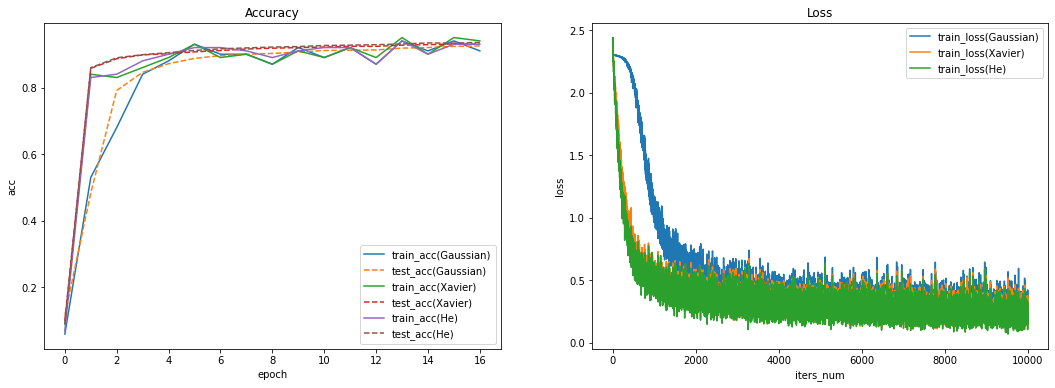

In [ ]:
#グラフ描画用
epoch=np.arange(iters_num/iter_per_epoch)
iters=np.arange(iters_num)

fig=plt.figure(figsize=(18,6),facecolor='w')
ax=fig.add_subplot('121')

for key in result.keys():
  ax.plot(epoch,result[key]['train_acc'],label='train_acc('+str(key)+')')
  ax.plot(epoch,result[key]['test_acc'],label='test_acc('+str(key)+')',linestyle='--')

ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.set_title('Accuracy')
plt.legend(loc='lower right')

ax=fig.add_subplot('122')
for key in result.keys():
  ax.plot(iters,result[key]['train_loss'],label='train_loss('+str(key)+')')

ax.set_xlabel('iters_num')
ax.set_ylabel('loss')
ax.set_title('Loss')
plt.legend(loc='upper right')
plt.show()

## Batch Normalization
https://kratzert.github.io/2016/02/12/understanding-the-gradient-flow-through-the-batch-normalization-layer.html  
Batch Normalizationは活性化関数の前に挿入するのが慣例

In [ ]:
class BatchNorm:
  def __init__(self,gamma,beta,momentum=0.9,running_mean=None,running_var=None):
    self.gamma=gamma
    self.beta=beta
    self.input_shape=None
    self.momentum=momentum

    self.running_mean=running_mean
    self.running_var=running_var

    self.xc=None
    self.std=None
    self.xn=None
    self.batch_size=None
    self.dgamma=None
    self.dbeta=None

  def forward(self,x,train_flag=True):
    self.input_shape=x.shape
    if x.ndim!=2:
      N,C,H,W=x.shape
      x=x.reshape(N,-1)

    out=self.__forward(x,train_flag)

    return out
    
  def __forward(self,x,train_flag):
    if self.running_mean is None:
      N,D=x.shape
      self.running_mean=np.zeros(D)
      self.running_var=np.zeros(D)

    if train_flag:
      mu=np.mean(x,axis=0)    #バッチごとの平均
      xc=x-mu
      var=np.mean(xc**2.0,axis=0)   #バッチごとの分散
      std=np.sqrt(var+10e-7)    #バッチごとの標準偏差
      xn=xc/std    #正規化

      self.batch_size=x.shape[0]
      self.xc=xc
      self.std=std
      self.xn=xn
      self.running_mean=self.momentum*self.running_mean+(1-self.momentum)*mu    #平均の移動平均
      self.running_var=self.momentum*self.running_var+(1-self.momentum)*var   #分散の移動平均

    else:
      xc=x-self.running_mean
      xn=xc/np.sqrt(self.running_var+10e-7)

    out=self.gamma*xn+self.beta
    return out

  def backward(self,dout):
    if dout.ndim!=2:
      N,C,H,W=dout.shape
      dout=dout.reshape(N,-1)

    dx=self.__backward(dout)
    dx=dx.reshape(self.input_shape)

    return dx

  def __backward(self,dout):
    dbeta=np.sum(dout,axis=0)
    dgamma=np.sum(self.xn*dout,axis=0)
    dgamma_xn=dout
    dxn=self.gamma*dgamma_xn
    distd=self.xc*np.sum(dxn,axis=0)
    dxc2=1./self.std*dxn
    dstd=-1./(self.std)**2*distd
    dvar=0.5/self.std*dstd
    dsq_xc=1./self.batch_size*np.ones([*dout.shape])*dvar
    dxc1=2.*self.xc*dsq_xc
    dx1=dxc1+dxc2
    dmu=-np.sum(dxc1+dxc2,axis=0)
    dx2=1./self.batch_size*np.ones([*dout.shape])*dmu
    dx=dx1+dx2

    self.dgamma=dgamma
    self.dbeta=dbeta

    return dx

In [ ]:
#DropoutとBatchNormに対応した多層ニューラルネットのクラス
from collections import OrderedDict
from common.layers import *

class MultiLayerNetExtend3:
  def __init__(self,input_size,hidden_size_list,output_size,
               activation='relu',weight_init_std='relu',weight_decay_lambda=0,
               use_dropout=False,dropout_ratio=0.5,use_batchnorm=False):
    self.input_size=input_size
    self.hidden_size_list=hidden_size_list
    self.hidden_layer_num=len(hidden_size_list)
    self.output_size=output_size
    self.weight_decay_lambda=weight_decay_lambda
    self.params={}
    self.use_dropout=use_dropout    #Dropoutを使うか否かのブール値
    self.dropout_ration=dropout_ratio    #Dropout率
    self.use_batchnorm=use_batchnorm    #BatchNormを使うか否かのブール値

    self.__init_weight(weight_init_std)
    self.__init_layers(activation)

  def __init_weight(self,weight_init_std):
    all_size_list=[self.input_size]+self.hidden_size_list+[self.output_size]
    scale=weight_init_std

    for idx in range(1,len(all_size_list)):
      if str(weight_init_std).lower() in ('relu','he'):
        scale=np.sqrt(2./all_size_list[idx-1])
      elif str(weight_init_std).lower() in ('sigmoid','xavier'):
        scale=1./np.sqrt(all_size_list[idx-1])

      self.params['W'+str(idx)]=\
        np.random.randn(all_size_list[idx-1],all_size_list[idx])*scale
      self.params['b'+str(idx)]=np.zeros(all_size_list[idx])

  def __init_layers(self,activation):
    activation_layer={'sigmoid':Sigmoid,'relu':Relu}
    self.layers=OrderedDict()
    for idx in range(1,self.hidden_layer_num+1):
      self.layers['Affine'+str(idx)]=Affine(self.params['W'+str(idx)],
                                            self.params['b'+str(idx)])
      
      #self.use_batchnorm==Trueの場合、BatchNorm Layerを追加
      if self.use_batchnorm:
        self.params['gamma'+str(idx)]=np.ones(self.hidden_size_list[idx-1])
        self.params['beta'+str(idx)]=np.zeros(self.hidden_size_list[idx-1])
        self.layers['BatchNorm'+str(idx)]=BatchNorm(self.params['gamma'+str(idx)],self.params['beta'+str(idx)])

      self.layers['Activation_function'+str(idx)]=activation_layer[activation]()

      #use_dropout==Trueの場合、Dropout Layerを追加
      if self.use_dropout:
        self.layers['Dropout'+str(idx)]=Dropout(self.dropout_ration)

    idx=self.hidden_layer_num+1
    self.layers['Affine'+str(idx)]=Affine(self.params['W'+str(idx)],self.params['b'+str(idx)])

    self.last_layer=SoftmaxWithLoss()

  def predict(self,x,train_flag=False):
    for key,layer in self.layers.items():
      #self.layersにキーDropoutかBatchNormが含まれている場合は、引数にtrain_flagを追加
      if 'Dropout' in key or 'BatchNorm' in key:    
        x=layer.forward(x,train_flag)
      else:
        x=layer.forward(x)

    return x

  def loss(self,x,t,train_flag=False):
    y=self.predict(x,train_flag)

    weight_decay=0
    for idx in range(1,self.hidden_layer_num+2):
      W=self.params['W'+str(idx)]
      weight_decay+=0.5*self.weight_decay_lambda*np.sum(W**2)

    loss=self.last_layer.forward(y,t)+weight_decay

    return loss

  def accuracy(self,x,t):
    y=self.predict(x,train_flag=False)
    y=np.argmax(y,axis=1)

    if t.ndim!=1:
      t=np.argmax(t,axis=1)

    accuracy=np.sum([y==t])/float(x.shape[0])
    return accuracy

  def gradient(self,x,t):
    self.loss(x,t,train_flag=True)
    dout=1
    dout=self.last_layer.backward(dout)

    layers=list(self.layers.values())
    layers.reverse()

    for layer in layers:
      dout=layer.backward(dout)

    grads={}
    for idx in range(1,self.hidden_layer_num+2):
      grads['W'+str(idx)]=self.layers['Affine'+str(idx)].dW+self.weight_decay_lambda*self.layers['Affine'+str(idx)].W
      grads['b'+str(idx)]=self.layers['Affine'+str(idx)].db

      #self.use_batchnormがTrueかつidxがself.hidden_layer_num+1ではない場合、gradsにdgammaとdbetaを追加
      if self.use_batchnorm and idx != self.hidden_layer_num+1:
        grads['gamma'+str(idx)]=self.layers['BatchNorm'+str(idx)].dgamma
        grads['beta'+str(idx)]=self.layers['BatchNorm'+str(idx)].dbeta

    return grads

============== 1/16 ==============
epoch:0 | train_acc : 0.16 bn_train_acc : 0.05
epoch:1 | train_acc : 0.09 bn_train_acc : 0.06
epoch:2 | train_acc : 0.09 bn_train_acc : 0.12
epoch:3 | train_acc : 0.11 bn_train_acc : 0.12
epoch:4 | train_acc : 0.12 bn_train_acc : 0.2
epoch:5 | train_acc : 0.14 bn_train_acc : 0.16
epoch:6 | train_acc : 0.05 bn_train_acc : 0.14
epoch:7 | train_acc : 0.12 bn_train_acc : 0.17
epoch:8 | train_acc : 0.1 bn_train_acc : 0.2
epoch:9 | train_acc : 0.2 bn_train_acc : 0.33
epoch:10 | train_acc : 0.12 bn_train_acc : 0.18
epoch:11 | train_acc : 0.15 bn_train_acc : 0.29
epoch:12 | train_acc : 0.12 bn_train_acc : 0.24
epoch:13 | train_acc : 0.11 bn_train_acc : 0.29
epoch:14 | train_acc : 0.1 bn_train_acc : 0.27
epoch:15 | train_acc : 0.09 bn_train_acc : 0.33
epoch:16 | train_acc : 0.14 bn_train_acc : 0.37
epoch:17 | train_acc : 0.12 bn_train_acc : 0.38
epoch:18 | train_acc : 0.1 bn_train_acc : 0.31
epoch:19 | train_acc : 0.07 bn_train_acc : 0.4


No handles with labels found to put in legend.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: overflow encountered in square
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:75: RuntimeWarning: invalid value encountered in double_scalars


============== 2/16 ==============
epoch:0 | train_acc : 0.09 bn_train_acc : 0.11
epoch:1 | train_acc : 0.08 bn_train_acc : 0.16
epoch:2 | train_acc : 0.13 bn_train_acc : 0.22
epoch:3 | train_acc : 0.12 bn_train_acc : 0.18
epoch:4 | train_acc : 0.12 bn_train_acc : 0.22
epoch:5 | train_acc : 0.11 bn_train_acc : 0.17
epoch:6 | train_acc : 0.09 bn_train_acc : 0.28
epoch:7 | train_acc : 0.16 bn_train_acc : 0.4
epoch:8 | train_acc : 0.1 bn_train_acc : 0.25
epoch:9 | train_acc : 0.08 bn_train_acc : 0.34
epoch:10 | train_acc : 0.14 bn_train_acc : 0.37
epoch:11 | train_acc : 0.11 bn_train_acc : 0.4
epoch:12 | train_acc : 0.16 bn_train_acc : 0.43
epoch:13 | train_acc : 0.16 bn_train_acc : 0.42
epoch:14 | train_acc : 0.17 bn_train_acc : 0.42
epoch:15 | train_acc : 0.1 bn_train_acc : 0.47
epoch:16 | train_acc : 0.09 bn_train_acc : 0.37
epoch:17 | train_acc : 0.12 bn_train_acc : 0.47
epoch:18 | train_acc : 0.11 bn_train_acc : 0.52
epoch:19 | train_acc : 0.13 bn_train_acc : 0.41


No handles with labels found to put in legend.


============== 3/16 ==============
epoch:0 | train_acc : 0.17 bn_train_acc : 0.03
epoch:1 | train_acc : 0.34 bn_train_acc : 0.1
epoch:2 | train_acc : 0.46 bn_train_acc : 0.18
epoch:3 | train_acc : 0.6 bn_train_acc : 0.24
epoch:4 | train_acc : 0.68 bn_train_acc : 0.25
epoch:5 | train_acc : 0.66 bn_train_acc : 0.25
epoch:6 | train_acc : 0.73 bn_train_acc : 0.32
epoch:7 | train_acc : 0.7 bn_train_acc : 0.32
epoch:8 | train_acc : 0.79 bn_train_acc : 0.4
epoch:9 | train_acc : 0.85 bn_train_acc : 0.42
epoch:10 | train_acc : 0.85 bn_train_acc : 0.41
epoch:11 | train_acc : 0.88 bn_train_acc : 0.54
epoch:12 | train_acc : 0.91 bn_train_acc : 0.46
epoch:13 | train_acc : 0.87 bn_train_acc : 0.46
epoch:14 | train_acc : 0.86 bn_train_acc : 0.6
epoch:15 | train_acc : 0.88 bn_train_acc : 0.59
epoch:16 | train_acc : 0.93 bn_train_acc : 0.65
epoch:17 | train_acc : 0.89 bn_train_acc : 0.59
epoch:18 | train_acc : 0.92 bn_train_acc : 0.65
epoch:19 | train_acc : 0.94 bn_train_acc : 0.67


No handles with labels found to put in legend.


============== 4/16 ==============
epoch:0 | train_acc : 0.09 bn_train_acc : 0.19
epoch:1 | train_acc : 0.46 bn_train_acc : 0.09
epoch:2 | train_acc : 0.48 bn_train_acc : 0.19
epoch:3 | train_acc : 0.58 bn_train_acc : 0.25
epoch:4 | train_acc : 0.63 bn_train_acc : 0.37
epoch:5 | train_acc : 0.73 bn_train_acc : 0.41
epoch:6 | train_acc : 0.85 bn_train_acc : 0.45
epoch:7 | train_acc : 0.79 bn_train_acc : 0.5
epoch:8 | train_acc : 0.82 bn_train_acc : 0.59
epoch:9 | train_acc : 0.84 bn_train_acc : 0.59
epoch:10 | train_acc : 0.84 bn_train_acc : 0.69
epoch:11 | train_acc : 0.82 bn_train_acc : 0.75
epoch:12 | train_acc : 0.87 bn_train_acc : 0.72
epoch:13 | train_acc : 0.84 bn_train_acc : 0.72
epoch:14 | train_acc : 0.84 bn_train_acc : 0.74
epoch:15 | train_acc : 0.91 bn_train_acc : 0.76
epoch:16 | train_acc : 0.91 bn_train_acc : 0.77
epoch:17 | train_acc : 0.89 bn_train_acc : 0.74
epoch:18 | train_acc : 0.96 bn_train_acc : 0.74


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.87 bn_train_acc : 0.77
============== 5/16 ==============
epoch:0 | train_acc : 0.14 bn_train_acc : 0.08
epoch:1 | train_acc : 0.08 bn_train_acc : 0.17
epoch:2 | train_acc : 0.14 bn_train_acc : 0.41
epoch:3 | train_acc : 0.13 bn_train_acc : 0.35
epoch:4 | train_acc : 0.16 bn_train_acc : 0.5
epoch:5 | train_acc : 0.16 bn_train_acc : 0.6
epoch:6 | train_acc : 0.13 bn_train_acc : 0.6
epoch:7 | train_acc : 0.1 bn_train_acc : 0.73
epoch:8 | train_acc : 0.09 bn_train_acc : 0.74
epoch:9 | train_acc : 0.12 bn_train_acc : 0.77
epoch:10 | train_acc : 0.21 bn_train_acc : 0.84
epoch:11 | train_acc : 0.22 bn_train_acc : 0.81
epoch:12 | train_acc : 0.16 bn_train_acc : 0.83
epoch:13 | train_acc : 0.22 bn_train_acc : 0.85
epoch:14 | train_acc : 0.23 bn_train_acc : 0.83
epoch:15 | train_acc : 0.26 bn_train_acc : 0.85
epoch:16 | train_acc : 0.24 bn_train_acc : 0.87
epoch:17 | train_acc : 0.2 bn_train_acc : 0.94
epoch:18 | train_acc : 0.23 bn_train_acc : 0.88


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.23 bn_train_acc : 0.89
============== 6/16 ==============
epoch:0 | train_acc : 0.21 bn_train_acc : 0.13
epoch:1 | train_acc : 0.06 bn_train_acc : 0.19
epoch:2 | train_acc : 0.22 bn_train_acc : 0.52
epoch:3 | train_acc : 0.15 bn_train_acc : 0.49
epoch:4 | train_acc : 0.16 bn_train_acc : 0.59
epoch:5 | train_acc : 0.19 bn_train_acc : 0.7
epoch:6 | train_acc : 0.14 bn_train_acc : 0.66
epoch:7 | train_acc : 0.07 bn_train_acc : 0.73
epoch:8 | train_acc : 0.2 bn_train_acc : 0.76
epoch:9 | train_acc : 0.17 bn_train_acc : 0.82
epoch:10 | train_acc : 0.15 bn_train_acc : 0.72
epoch:11 | train_acc : 0.11 bn_train_acc : 0.78
epoch:12 | train_acc : 0.09 bn_train_acc : 0.77
epoch:13 | train_acc : 0.14 bn_train_acc : 0.69
epoch:14 | train_acc : 0.16 bn_train_acc : 0.77
epoch:15 | train_acc : 0.05 bn_train_acc : 0.76
epoch:16 | train_acc : 0.13 bn_train_acc : 0.86
epoch:17 | train_acc : 0.14 bn_train_acc : 0.83
epoch:18 | train_acc : 0.15 bn_train_acc : 0.79


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.05 bn_train_acc : 0.84
============== 7/16 ==============
epoch:0 | train_acc : 0.14 bn_train_acc : 0.09
epoch:1 | train_acc : 0.11 bn_train_acc : 0.3
epoch:2 | train_acc : 0.09 bn_train_acc : 0.56
epoch:3 | train_acc : 0.17 bn_train_acc : 0.71
epoch:4 | train_acc : 0.13 bn_train_acc : 0.73
epoch:5 | train_acc : 0.14 bn_train_acc : 0.79
epoch:6 | train_acc : 0.1 bn_train_acc : 0.73
epoch:7 | train_acc : 0.15 bn_train_acc : 0.74
epoch:8 | train_acc : 0.07 bn_train_acc : 0.67
epoch:9 | train_acc : 0.12 bn_train_acc : 0.71
epoch:10 | train_acc : 0.16 bn_train_acc : 0.67
epoch:11 | train_acc : 0.11 bn_train_acc : 0.74
epoch:12 | train_acc : 0.09 bn_train_acc : 0.74
epoch:13 | train_acc : 0.11 bn_train_acc : 0.72
epoch:14 | train_acc : 0.13 bn_train_acc : 0.82
epoch:15 | train_acc : 0.09 bn_train_acc : 0.76
epoch:16 | train_acc : 0.16 bn_train_acc : 0.74
epoch:17 | train_acc : 0.12 bn_train_acc : 0.7
epoch:18 | train_acc : 0.1 bn_train_acc : 0.73


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.1 bn_train_acc : 0.68
============== 8/16 ==============
epoch:0 | train_acc : 0.14 bn_train_acc : 0.09
epoch:1 | train_acc : 0.16 bn_train_acc : 0.45
epoch:2 | train_acc : 0.13 bn_train_acc : 0.63
epoch:3 | train_acc : 0.07 bn_train_acc : 0.63
epoch:4 | train_acc : 0.18 bn_train_acc : 0.72
epoch:5 | train_acc : 0.14 bn_train_acc : 0.6
epoch:6 | train_acc : 0.15 bn_train_acc : 0.57
epoch:7 | train_acc : 0.11 bn_train_acc : 0.55
epoch:8 | train_acc : 0.1 bn_train_acc : 0.58
epoch:9 | train_acc : 0.1 bn_train_acc : 0.62
epoch:10 | train_acc : 0.07 bn_train_acc : 0.49
epoch:11 | train_acc : 0.14 bn_train_acc : 0.56
epoch:12 | train_acc : 0.15 bn_train_acc : 0.52
epoch:13 | train_acc : 0.12 bn_train_acc : 0.63
epoch:14 | train_acc : 0.15 bn_train_acc : 0.54
epoch:15 | train_acc : 0.18 bn_train_acc : 0.56
epoch:16 | train_acc : 0.14 bn_train_acc : 0.59
epoch:17 | train_acc : 0.03 bn_train_acc : 0.52
epoch:18 | train_acc : 0.12 bn_train_acc : 0.49


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.09 bn_train_acc : 0.54
============== 9/16 ==============
epoch:0 | train_acc : 0.17 bn_train_acc : 0.13
epoch:1 | train_acc : 0.12 bn_train_acc : 0.37
epoch:2 | train_acc : 0.2 bn_train_acc : 0.46
epoch:3 | train_acc : 0.1 bn_train_acc : 0.36
epoch:4 | train_acc : 0.12 bn_train_acc : 0.43
epoch:5 | train_acc : 0.1 bn_train_acc : 0.4
epoch:6 | train_acc : 0.08 bn_train_acc : 0.46
epoch:7 | train_acc : 0.07 bn_train_acc : 0.39
epoch:8 | train_acc : 0.16 bn_train_acc : 0.39
epoch:9 | train_acc : 0.15 bn_train_acc : 0.37
epoch:10 | train_acc : 0.1 bn_train_acc : 0.48
epoch:11 | train_acc : 0.12 bn_train_acc : 0.4
epoch:12 | train_acc : 0.1 bn_train_acc : 0.39
epoch:13 | train_acc : 0.11 bn_train_acc : 0.48
epoch:14 | train_acc : 0.12 bn_train_acc : 0.55
epoch:15 | train_acc : 0.1 bn_train_acc : 0.43
epoch:16 | train_acc : 0.12 bn_train_acc : 0.41
epoch:17 | train_acc : 0.07 bn_train_acc : 0.41
epoch:18 | train_acc : 0.08 bn_train_acc : 0.43
epoch:19 | train_acc : 

No handles with labels found to put in legend.


============== 10/16 ==============
epoch:0 | train_acc : 0.17 bn_train_acc : 0.21
epoch:1 | train_acc : 0.12 bn_train_acc : 0.48
epoch:2 | train_acc : 0.13 bn_train_acc : 0.54
epoch:3 | train_acc : 0.09 bn_train_acc : 0.48
epoch:4 | train_acc : 0.1 bn_train_acc : 0.39
epoch:5 | train_acc : 0.12 bn_train_acc : 0.47
epoch:6 | train_acc : 0.1 bn_train_acc : 0.41
epoch:7 | train_acc : 0.09 bn_train_acc : 0.41
epoch:8 | train_acc : 0.06 bn_train_acc : 0.45
epoch:9 | train_acc : 0.15 bn_train_acc : 0.49
epoch:10 | train_acc : 0.12 bn_train_acc : 0.43
epoch:11 | train_acc : 0.17 bn_train_acc : 0.48
epoch:12 | train_acc : 0.12 bn_train_acc : 0.48
epoch:13 | train_acc : 0.15 bn_train_acc : 0.49
epoch:14 | train_acc : 0.08 bn_train_acc : 0.46
epoch:15 | train_acc : 0.07 bn_train_acc : 0.51
epoch:16 | train_acc : 0.1 bn_train_acc : 0.55
epoch:17 | train_acc : 0.15 bn_train_acc : 0.58
epoch:18 | train_acc : 0.09 bn_train_acc : 0.52


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.14 bn_train_acc : 0.57
============== 11/16 ==============
epoch:0 | train_acc : 0.14 bn_train_acc : 0.09
epoch:1 | train_acc : 0.16 bn_train_acc : 0.27
epoch:2 | train_acc : 0.11 bn_train_acc : 0.4
epoch:3 | train_acc : 0.13 bn_train_acc : 0.46
epoch:4 | train_acc : 0.12 bn_train_acc : 0.37
epoch:5 | train_acc : 0.15 bn_train_acc : 0.34
epoch:6 | train_acc : 0.12 bn_train_acc : 0.39
epoch:7 | train_acc : 0.13 bn_train_acc : 0.36
epoch:8 | train_acc : 0.18 bn_train_acc : 0.44
epoch:9 | train_acc : 0.17 bn_train_acc : 0.42
epoch:10 | train_acc : 0.24 bn_train_acc : 0.49
epoch:11 | train_acc : 0.13 bn_train_acc : 0.4
epoch:12 | train_acc : 0.08 bn_train_acc : 0.34
epoch:13 | train_acc : 0.23 bn_train_acc : 0.44
epoch:14 | train_acc : 0.1 bn_train_acc : 0.4
epoch:15 | train_acc : 0.11 bn_train_acc : 0.39
epoch:16 | train_acc : 0.12 bn_train_acc : 0.35
epoch:17 | train_acc : 0.11 bn_train_acc : 0.37
epoch:18 | train_acc : 0.12 bn_train_acc : 0.46


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.13 bn_train_acc : 0.41
============== 12/16 ==============
epoch:0 | train_acc : 0.14 bn_train_acc : 0.22
epoch:1 | train_acc : 0.12 bn_train_acc : 0.48
epoch:2 | train_acc : 0.11 bn_train_acc : 0.37
epoch:3 | train_acc : 0.17 bn_train_acc : 0.45
epoch:4 | train_acc : 0.13 bn_train_acc : 0.39
epoch:5 | train_acc : 0.1 bn_train_acc : 0.39
epoch:6 | train_acc : 0.12 bn_train_acc : 0.3
epoch:7 | train_acc : 0.06 bn_train_acc : 0.28
epoch:8 | train_acc : 0.11 bn_train_acc : 0.25
epoch:9 | train_acc : 0.06 bn_train_acc : 0.27
epoch:10 | train_acc : 0.13 bn_train_acc : 0.42
epoch:11 | train_acc : 0.1 bn_train_acc : 0.37
epoch:12 | train_acc : 0.14 bn_train_acc : 0.33
epoch:13 | train_acc : 0.15 bn_train_acc : 0.28
epoch:14 | train_acc : 0.15 bn_train_acc : 0.38
epoch:15 | train_acc : 0.11 bn_train_acc : 0.35
epoch:16 | train_acc : 0.11 bn_train_acc : 0.35
epoch:17 | train_acc : 0.15 bn_train_acc : 0.39
epoch:18 | train_acc : 0.19 bn_train_acc : 0.37
epoch:19 | train_

No handles with labels found to put in legend.


============== 13/16 ==============
epoch:0 | train_acc : 0.14 bn_train_acc : 0.24
epoch:1 | train_acc : 0.14 bn_train_acc : 0.26
epoch:2 | train_acc : 0.15 bn_train_acc : 0.18
epoch:3 | train_acc : 0.1 bn_train_acc : 0.2
epoch:4 | train_acc : 0.18 bn_train_acc : 0.14
epoch:5 | train_acc : 0.11 bn_train_acc : 0.21
epoch:6 | train_acc : 0.12 bn_train_acc : 0.27
epoch:7 | train_acc : 0.13 bn_train_acc : 0.24
epoch:8 | train_acc : 0.06 bn_train_acc : 0.23
epoch:9 | train_acc : 0.13 bn_train_acc : 0.31
epoch:10 | train_acc : 0.17 bn_train_acc : 0.38
epoch:11 | train_acc : 0.07 bn_train_acc : 0.31
epoch:12 | train_acc : 0.14 bn_train_acc : 0.31
epoch:13 | train_acc : 0.09 bn_train_acc : 0.32
epoch:14 | train_acc : 0.09 bn_train_acc : 0.33
epoch:15 | train_acc : 0.09 bn_train_acc : 0.34
epoch:16 | train_acc : 0.18 bn_train_acc : 0.32
epoch:17 | train_acc : 0.15 bn_train_acc : 0.37
epoch:18 | train_acc : 0.15 bn_train_acc : 0.34


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.15 bn_train_acc : 0.33
============== 14/16 ==============
epoch:0 | train_acc : 0.18 bn_train_acc : 0.17
epoch:1 | train_acc : 0.17 bn_train_acc : 0.39
epoch:2 | train_acc : 0.15 bn_train_acc : 0.41
epoch:3 | train_acc : 0.11 bn_train_acc : 0.3
epoch:4 | train_acc : 0.16 bn_train_acc : 0.37
epoch:5 | train_acc : 0.08 bn_train_acc : 0.24
epoch:6 | train_acc : 0.09 bn_train_acc : 0.29
epoch:7 | train_acc : 0.06 bn_train_acc : 0.23
epoch:8 | train_acc : 0.14 bn_train_acc : 0.34
epoch:9 | train_acc : 0.1 bn_train_acc : 0.33
epoch:10 | train_acc : 0.08 bn_train_acc : 0.28
epoch:11 | train_acc : 0.12 bn_train_acc : 0.33
epoch:12 | train_acc : 0.11 bn_train_acc : 0.3
epoch:13 | train_acc : 0.12 bn_train_acc : 0.36
epoch:14 | train_acc : 0.12 bn_train_acc : 0.3
epoch:15 | train_acc : 0.12 bn_train_acc : 0.34
epoch:16 | train_acc : 0.11 bn_train_acc : 0.23
epoch:17 | train_acc : 0.13 bn_train_acc : 0.26
epoch:18 | train_acc : 0.08 bn_train_acc : 0.25


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.06 bn_train_acc : 0.32
============== 15/16 ==============
epoch:0 | train_acc : 0.14 bn_train_acc : 0.14
epoch:1 | train_acc : 0.14 bn_train_acc : 0.24
epoch:2 | train_acc : 0.19 bn_train_acc : 0.38
epoch:3 | train_acc : 0.07 bn_train_acc : 0.26
epoch:4 | train_acc : 0.14 bn_train_acc : 0.38
epoch:5 | train_acc : 0.16 bn_train_acc : 0.36
epoch:6 | train_acc : 0.08 bn_train_acc : 0.34
epoch:7 | train_acc : 0.06 bn_train_acc : 0.35
epoch:8 | train_acc : 0.06 bn_train_acc : 0.28
epoch:9 | train_acc : 0.1 bn_train_acc : 0.31
epoch:10 | train_acc : 0.13 bn_train_acc : 0.29
epoch:11 | train_acc : 0.06 bn_train_acc : 0.41
epoch:12 | train_acc : 0.17 bn_train_acc : 0.35
epoch:13 | train_acc : 0.19 bn_train_acc : 0.35
epoch:14 | train_acc : 0.13 bn_train_acc : 0.24
epoch:15 | train_acc : 0.12 bn_train_acc : 0.34
epoch:16 | train_acc : 0.14 bn_train_acc : 0.31
epoch:17 | train_acc : 0.11 bn_train_acc : 0.4
epoch:18 | train_acc : 0.12 bn_train_acc : 0.37


No handles with labels found to put in legend.


epoch:19 | train_acc : 0.16 bn_train_acc : 0.41
============== 16/16 ==============
epoch:0 | train_acc : 0.18 bn_train_acc : 0.18
epoch:1 | train_acc : 0.1 bn_train_acc : 0.26
epoch:2 | train_acc : 0.08 bn_train_acc : 0.26
epoch:3 | train_acc : 0.13 bn_train_acc : 0.42
epoch:4 | train_acc : 0.08 bn_train_acc : 0.28
epoch:5 | train_acc : 0.13 bn_train_acc : 0.39
epoch:6 | train_acc : 0.15 bn_train_acc : 0.31
epoch:7 | train_acc : 0.12 bn_train_acc : 0.33
epoch:8 | train_acc : 0.18 bn_train_acc : 0.32
epoch:9 | train_acc : 0.11 bn_train_acc : 0.32
epoch:10 | train_acc : 0.08 bn_train_acc : 0.37
epoch:11 | train_acc : 0.09 bn_train_acc : 0.37
epoch:12 | train_acc : 0.13 bn_train_acc : 0.29
epoch:13 | train_acc : 0.13 bn_train_acc : 0.23
epoch:14 | train_acc : 0.08 bn_train_acc : 0.39
epoch:15 | train_acc : 0.15 bn_train_acc : 0.37
epoch:16 | train_acc : 0.16 bn_train_acc : 0.34
epoch:17 | train_acc : 0.11 bn_train_acc : 0.32
epoch:18 | train_acc : 0.1 bn_train_acc : 0.35
epoch:19 | train

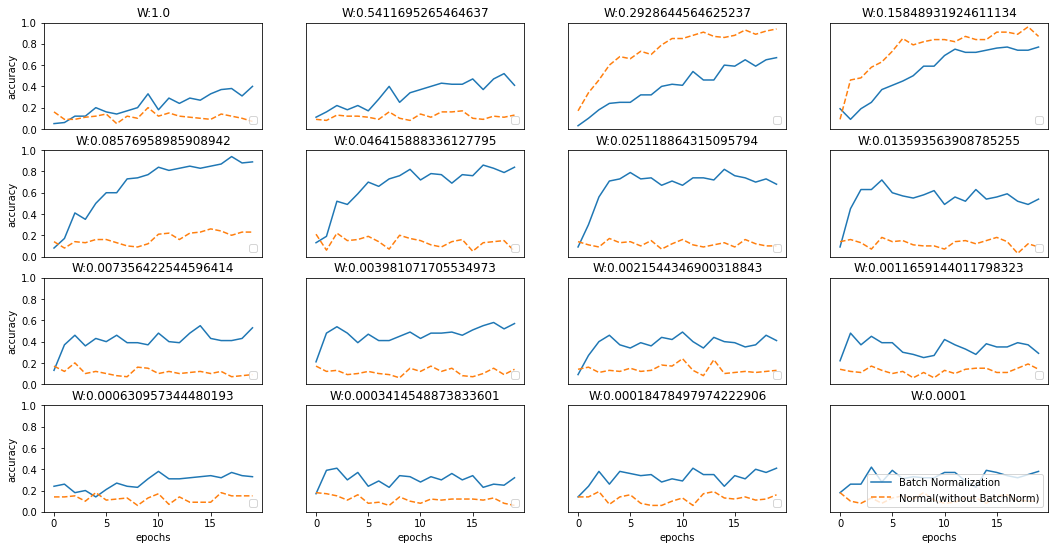

In [ ]:
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

x_train=x_train[:1000]
t_train=t_train[:1000]

max_epochs=20
train_size=x_train.shape[0]
iters_num=1000000000
batch_size=100
iter_per_epoch=max(train_size/batch_size,1)
learning_rate=0.01
use_batchnorm=True

def __train(weight_init_std):
  network=MultiLayerNetExtend3(input_size=784,hidden_size_list=[100,100,100,100,100],
                              output_size=10,weight_init_std=weight_init_std)
  bn_network=MultiLayerNetExtend3(input_size=784,hidden_size_list=[100,100,100,100,100],
                              output_size=10,use_batchnorm=use_batchnorm,
                              weight_init_std=weight_init_std)
  optimizer=SGD(lr=learning_rate)

  train_acc_list=[]
  bn_train_acc_list=[]
  epoch_cnt=0

  for i in range(iters_num):
    batch_mask=np.random.choice(train_size,batch_size)
    x_batch=x_train[batch_mask]
    t_batch=t_train[batch_mask]

    for _network in (bn_network,network):
      grads=_network.gradient(x_batch,t_batch)
      _network.params=optimizer.update(_network.params,grads)

    if i % iter_per_epoch==0:
      train_acc=network.accuracy(x_batch,t_batch)
      bn_train_acc=bn_network.accuracy(x_batch,t_batch)
      train_acc_list.append(train_acc)
      bn_train_acc_list.append(bn_train_acc)
      
      print('epoch:'+str(epoch_cnt)+' | '+'train_acc :',train_acc,'bn_train_acc :',bn_train_acc)
      epoch_cnt+=1
      if epoch_cnt>=max_epochs:
        break
    
  return train_acc_list, bn_train_acc_list

weight_scale_list=np.logspace(0,-4,num=16)
x=np.arange(max_epochs)
plt.figure(figsize=(18,9),facecolor='w')

for i, w in enumerate(weight_scale_list):
  print( "============== " + str(i+1) + "/16" + " ==============")
  train_acc_list, bn_train_acc_list = __train(w)

  plt.subplot(4,4,i+1)
  plt.title("W:" + str(w))
  if i == 15:
      plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
      plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
  else:
      plt.plot(x, bn_train_acc_list, markevery=2)
      plt.plot(x, train_acc_list, linestyle="--", markevery=2)

  plt.ylim(0, 1.0)
  if i % 4:
      plt.yticks([])
  else:
      plt.ylabel("accuracy")
  if i < 12:
      plt.xticks([])
  else:
      plt.xlabel("epochs")
  plt.legend(loc='lower right')
  
plt.show()

## 正則化（Regurization）

### 過学習
過学習が起きる要因として主に、

* パラメータを大量に持ち、表現力の高いモデルであること
* 訓練データが少ないこと

が挙げられる

In [ ]:
#初期値に対応した多層ニューラルネット
from collections import OrderedDict
from common.layers import *

class MultiLayerNet2:
  def __init__(self,input_size,hidden_size_list,output_size,
               activation='relu',weight_init_std='he'):
    self.input_size=input_size
    self.hidden_size_list=hidden_size_list
    self.hidden_layer_num=len(hidden_size_list)
    self.output_size=output_size
    self.params={}

    self.__init_weight(weight_init_std)
    self.__init_layers(activation)

  def __init_weight(self,weight_init_std):
    all_size_list=[self.input_size]+self.hidden_size_list+[self.output_size]
    scale=weight_init_std

    for idx in range(1,len(all_size_list)):
      if str(weight_init_std).lower() in ('relu','he'):
        scale=np.sqrt(2./all_size_list[idx-1])
      elif str(weight_init_std).lower() in ('sigmoid','xavier'):
        scale=1./np.sqrt(all_size_list[idx-1])

      self.params['W'+str(idx)]=\
        np.random.randn(all_size_list[idx-1],all_size_list[idx])*scale
      self.params['b'+str(idx)]=np.zeros(all_size_list[idx])

  def __init_layers(self,activation):
    activation_layer={'sigmoid':Sigmoid,'relu':Relu}
    self.layers=OrderedDict()
    for idx in range(1,self.hidden_layer_num+1):
      self.layers['Affine'+str(idx)]=Affine(self.params['W'+str(idx)],
                                            self.params['b'+str(idx)])
      self.layers['Activation_function'+str(idx)]=activation_layer[activation]()

    idx=self.hidden_layer_num+1
    self.layers['Affine'+str(idx)]=Affine(self.params['W'+str(idx)],self.params['b'+str(idx)])
    self.last_layer=SoftmaxWithLoss()

  def predict(self,x):
    for layer in self.layers.values():
      x=layer.forward(x)

    return x

  def loss(self,x,t):
    y=self.predict(x)
    loss=self.last_layer.forward(y,t)

    return loss

  def accuracy(self,x,t):
    y=self.predict(x)
    y=np.argmax(y,axis=1)

    if t.ndim!=1:
      t=np.argmax(t,axis=1)

    accuracy=np.sum([y==t])/float(x.shape[0])
    return accuracy

  def gradient(self,x,t):
    self.loss(x,t)
    dout=1
    dout=self.last_layer.backward(dout)

    layers=list(self.layers.values())
    layers.reverse()

    for layer in layers:
      dout=layer.backward(dout)

    grads={}
    for idx in range(1,self.hidden_layer_num+2):
      grads['W'+str(idx)]=self.layers['Affine'+str(idx)].dW
      grads['b'+str(idx)]=self.layers['Affine'+str(idx)].db

    return grads

In [ ]:
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

x_train=x_train[:300]
t_train=t_train[:300]

max_epochs=201
train_size=x_train.shape[0]
iters_num=1000000000
batch_size=100
iter_per_epoch=max(train_size/batch_size,1)

network=MultiLayerNet2(input_size=784,hidden_size_list=[100,100,100,100,100,100],output_size=10)
optimizer=SGD(lr=0.01)

train_acc_list=[]
test_acc_list=[]
train_loss_list=[]
epoch_cnt=0

for i in range(iters_num):
  batch_mask=np.random.choice(train_size,batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  grad=network.gradient(x_batch,t_batch)
  network.params=optimizer.update(network.params,grad)
  loss=network.loss(x_batch,t_batch)
  train_loss_list.append(loss)

  if i % iter_per_epoch==0:
    train_acc=network.accuracy(x_batch,t_batch)
    test_acc=network.accuracy(x_test,t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print('train_acc :',train_acc,'test_acc :',test_acc)
    epoch_cnt+=1
    if epoch_cnt>=max_epochs:
      break


train_acc : 0.11 test_acc : 0.1293
train_acc : 0.18 test_acc : 0.1341
train_acc : 0.25 test_acc : 0.141
train_acc : 0.21 test_acc : 0.1445
train_acc : 0.23 test_acc : 0.1538
train_acc : 0.18 test_acc : 0.1701
train_acc : 0.29 test_acc : 0.1863
train_acc : 0.32 test_acc : 0.1943
train_acc : 0.31 test_acc : 0.2051
train_acc : 0.32 test_acc : 0.2182
train_acc : 0.32 test_acc : 0.2279
train_acc : 0.37 test_acc : 0.2399
train_acc : 0.37 test_acc : 0.2502
train_acc : 0.41 test_acc : 0.2584
train_acc : 0.42 test_acc : 0.273
train_acc : 0.47 test_acc : 0.2858
train_acc : 0.43 test_acc : 0.3009
train_acc : 0.63 test_acc : 0.3121
train_acc : 0.51 test_acc : 0.3269
train_acc : 0.53 test_acc : 0.3393
train_acc : 0.54 test_acc : 0.3547
train_acc : 0.5 test_acc : 0.3642
train_acc : 0.51 test_acc : 0.3755
train_acc : 0.54 test_acc : 0.3792
train_acc : 0.6 test_acc : 0.4053
train_acc : 0.63 test_acc : 0.4244
train_acc : 0.61 test_acc : 0.4284
train_acc : 0.69 test_acc : 0.4435
train_acc : 0.64 test_ac

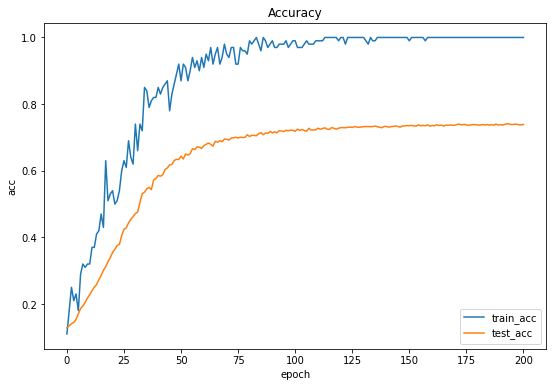

In [ ]:
epoch=np.arange(max_epochs)

plt.figure(figsize=(9,6),facecolor='w')
plt.plot(epoch,train_acc_list,label='train_acc')
plt.plot(epoch,test_acc_list,label='test_acc')
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Weight Decay(荷重減衰)
損失関数（重み）が大きな値を取らないように、ペナルティを課す  
順伝搬時は損失関数にノルムの項を加える  
逆伝搬時は重みWの勾配にノルムの微分を加える（L2正則化ならλW）

* L2正則化（Ridge）  
  * L2ノルム: 1 / 2 * λ * Σ (W^2)  
  * 一般的によく使われている
  * 重みが0ぴったりにはほぼならない

* L1正則化（Lasso）
  * L1ノルム： λ * Σ |W|  
  * 重みがスパースになる（0が増える）ため、以下の効果がある
    * メモリ使用量の削減
    * 計算量の削減
    * 正則化の効果
    * 特徴選択を自動的に行なっているとみなせる



In [ ]:
#初期値と正則化に対応した多層ニューラルネット
from collections import OrderedDict
from common.layers import *

class MultiLayerNet3:
  def __init__(self,input_size,hidden_size_list,output_size,
               activation='relu',weight_init_std='he',weight_decay_lambda=0):
    self.input_size=input_size
    self.hidden_size_list=hidden_size_list
    self.hidden_layer_num=len(hidden_size_list)
    self.output_size=output_size
    self.weight_decay_lambda=weight_decay_lambda
    self.params={}

    self.__init_weight(weight_init_std)
    self.__init_layers(activation)

  def __init_weight(self,weight_init_std):
    all_size_list=[self.input_size]+self.hidden_size_list+[self.output_size]
    scale=weight_init_std

    for idx in range(1,len(all_size_list)):
      if str(weight_init_std).lower() in ('relu','he'):
        scale=np.sqrt(2./all_size_list[idx-1])
      elif str(weight_init_std).lower() in ('sigmoid','xavier'):
        scale=1./np.sqrt(all_size_list[idx-1])

      self.params['W'+str(idx)]=\
        np.random.randn(all_size_list[idx-1],all_size_list[idx])*scale
      self.params['b'+str(idx)]=np.zeros(all_size_list[idx])

  def __init_layers(self,activation):
    activation_layer={'sigmoid':Sigmoid,'relu':Relu}
    self.layers=OrderedDict()
    for idx in range(1,self.hidden_layer_num+1):
      self.layers['Affine'+str(idx)]=Affine(self.params['W'+str(idx)],
                                            self.params['b'+str(idx)])
      self.layers['Activation_function'+str(idx)]=activation_layer[activation]()

    idx=self.hidden_layer_num+1
    self.layers['Affine'+str(idx)]=Affine(self.params['W'+str(idx)],self.params['b'+str(idx)])
    self.last_layer=SoftmaxWithLoss()

  def predict(self,x):
    for layer in self.layers.values():
      x=layer.forward(x)

    return x

  def loss(self,x,t):
    y=self.predict(x)

    weight_decay=0
    for idx in range(1,self.hidden_layer_num+2):
      W=self.params['W'+str(idx)]
      weight_decay+=0.5*self.weight_decay_lambda*np.sum(W**2)   #L2ノルム： 0.5*λ*Σ(W^2)

    loss=self.last_layer.forward(y,t)+weight_decay  #損失にL2ノルムを加える

    return loss

  def accuracy(self,x,t):
    y=self.predict(x)
    y=np.argmax(y,axis=1)

    if t.ndim!=1:
      t=np.argmax(t,axis=1)

    accuracy=np.sum([y==t])/float(x.shape[0])
    return accuracy

  def gradient(self,x,t):
    self.loss(x,t)
    dout=1
    dout=self.last_layer.backward(dout)

    layers=list(self.layers.values())
    layers.reverse()

    for layer in layers:
      dout=layer.backward(dout)

    grads={}
    for idx in range(1,self.hidden_layer_num+2):
      grads['W'+str(idx)]=self.layers['Affine'+str(idx)].dW+self.weight_decay_lambda*self.layers['Affine'+str(idx)].W   #勾配にL2ノルムの微分（λ*W）を加える
      grads['b'+str(idx)]=self.layers['Affine'+str(idx)].db

    return grads

In [ ]:
#意図的に過学習を生じさせ、正則化の効果を見る
from common.layers import *
from dataset.mnist import load_mnist

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

x_train=x_train[:300]
t_train=t_train[:300]

train_size=x_train.shape[0]
max_epochs=201
iters_num=10000
batch_size=100
lr=0.01
iter_per_epoch=max(train_size/batch_size,1)
epoch_cnt=0

optimizer=SGD()
weight_decay_dict={'lambda=0':0,'lambda=0.1':0.1,'lambda=0.2':0.2}
network_dict={}
result={}

for key1 in weight_decay_dict.keys():
  network_dict[key1]=MultiLayerNet3(input_size=784,
                                    hidden_size_list=[100,100,100,100,100],
                                    output_size=10,weight_init_std='He',
                                    weight_decay_lambda=weight_decay_dict[key1])
  result[key1]={}
  for key2 in ('train_acc','test_acc','train_loss'):
    result[key1][key2]=[]

for i in range(iters_num):

  batch_mask=np.random.choice(train_size,batch_size)
  x_batch=x_train[batch_mask]
  t_batch=t_train[batch_mask]

  for key in weight_decay_dict.keys():
    grads=network_dict[key].gradient(x_batch,t_batch)
    network_dict[key].params=optimizer.update(network_dict[key].params,grads)
    loss=network_dict[key].loss(x_batch,t_batch)
    result[key]['train_loss'].append(loss)

  if i % iter_per_epoch==0:
    print('epoch=',int(i/iter_per_epoch))
    for key in weight_decay_dict.keys():
      train_acc=network_dict[key].accuracy(x_batch,t_batch)
      test_acc=network_dict[key].accuracy(x_test,t_test)

      result[key]['train_acc'].append(train_acc)
      result[key]['test_acc'].append(test_acc)

      print('train_acc('+str(key)+'):'+str(train_acc)+\
            ' test_acc('+str(key)+'):'+str(test_acc))
    epoch_cnt+=1
    if epoch_cnt>=max_epochs:
      break

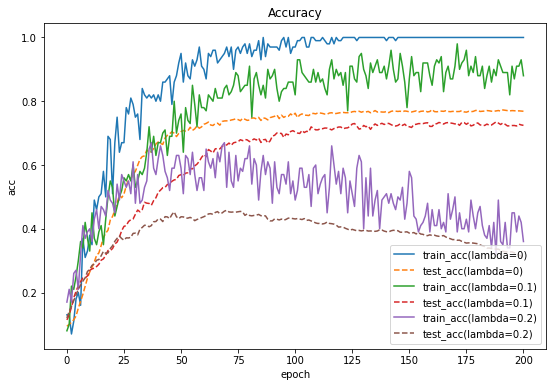

In [ ]:
#グラフ描画用
epoch=np.arange(max_epochs)

fig=plt.figure(figsize=(9,6),facecolor='w')
ax=fig.add_subplot('111')

for key in result.keys():
  ax.plot(epoch,result[key]['train_acc'],label='train_acc('+str(key)+')')
  ax.plot(epoch,result[key]['test_acc'],label='test_acc('+str(key)+')',linestyle='--')

ax.set_xlabel('epoch')
ax.set_ylabel('acc')
ax.set_title('Accuracy')
plt.legend(loc='lower right')

plt.show()

### Dropout
* forwardの処理  
dropout対象のノードの出力
 y = 0  
* backwardの処理  
dropout対象のノードの逆伝搬
 dx = 0  



In [ ]:
#Dropout layer
class Dropout:
  def __init__(self,dropout_ratio=0.5):
    self.dropout_ratio=dropout_ratio
    self.mask=None

  def forward(self,x,train_flag=True):
    if train_flag:
      #一様分布からx.shapeの0〜１の乱数を発生させ、dropout_ratioよりも低い場合はFalse（=0）とする
      self.mask=np.random.rand(*x.shape)>self.dropout_ratio
      return x*self.mask
    else:   #train_flagがFalse（テスト時）の場合はDropoutした割合の逆数を乗算する
      return x*(1.0-self.dropout_ratio)

  def backward(self,dout):
    return dout*self.mask

In [ ]:
#ニューラルネットの訓練を行うクラス
class Trainer2:
  def __init__(self,network,
               x_train,t_train,x_test,t_test,
               epochs=20,mini_batch_size=100,
               optimizer='SGD',optimizer_param={'lr':0.01},
               evaluate_sample_num_per_epoch=None,verbose=True):
    
    self.network=network

    self.x_train=x_train
    self.t_train=t_train
    self.x_test=x_test
    self.t_test=t_test
    self.train_size=self.x_train.shape[0]

    self.epochs=epochs
    self.batch_size=mini_batch_size

    #データ全体の重みを更新するのに必要な繰り返し回数（=1epochあたりの繰り返し回数）
    self.iter_per_epoch=max(self.train_size/mini_batch_size,1)

    #指定したepoch数学習するために必要な繰り返し回数
    self.max_iter=int(self.iter_per_epoch*epochs)

    self.current_iter=0   #現在の繰り返し回数
    self.current_epoch=0    #現在のepoch

    optimizer_class_dict={'sgd':SGD,'momentum':Momentum,'nesterov':Nesterov,
                          'adagrad':AdaGrad,'rmsprop':RMSprop,'adam':Adam}

    self.optimizer=optimizer_class_dict[optimizer.lower()](**optimizer_param)

    self.train_acc_list=[]
    self.test_acc_list=[]
    self.train_loss_list=[]

    #1epochごとに評価するデータのサンプル数
    self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch
    self.verbose=verbose    #正答率、誤差などの詳細を表示するか否かのブール値

  #重みの更新一回分を行う関数
  def train_step(self):
    batch_mask=np.random.choice(self.train_size,self.batch_size)
    x_batch=self.x_train[batch_mask]
    t_batch=self.t_train[batch_mask]

    grads=self.network.gradient(x_batch,t_batch)
    self.optimizer.update(self.network.params,grads)

    loss=self.network.loss(x_batch,t_batch)
    self.train_loss_list.append(loss)

    if self.verbose:
      print('train_loss:'+str(loss))

    if self.current_iter%self.iter_per_epoch==0:
      self.current_epoch+=1

      x_train_sample,t_train_sample=self.x_train,self.t_train
      x_test_sample,t_test_sample=self.x_test,self.t_test

      if not self.evaluate_sample_num_per_epoch is None:
        t=self.evaluate_sample_num_per_epoch
        x_train_sample,t_train_sample=x_train_sample[:t],t_train_sample[:t]
        x_test_sample,t_test_sample=x_test_sample[:t],t_test_sample[:t]

      train_acc=self.network.accuracy(x_train_sample,t_train_sample)
      test_acc=self.network.accuracy(x_test_sample,t_test_sample)
      self.train_acc_list.append(train_acc)
      self.test_acc_list.append(test_acc)

      if self.verbose:
        print('=== epoch:'+str(self.current_epoch),', train_acc:'+str(train_acc),', test_acc:'+str(test_acc)+' ===')

    self.current_iter+=1

  def train(self):
    for i in range(self.max_iter):
      self.train_step()

    test_acc=self.network.accuracy(x_test,t_test)   #学習後のテストデータの正答率
    
    if self.verbose:
      print("=============== Final Test Accuracy ===============")
      print("test acc:" + str(test_acc))


In [ ]:
#Dropoutに対応した多層ニューラルネットのクラス
from collections import OrderedDict
from common.layers import *

class MultiLayerNetExtend2:
  def __init__(self,input_size,hidden_size_list,output_size,
               activation='relu',weight_init_std='he',weight_decay_lambda=0,
               use_dropout=False,dropout_ratio=0.5):
    self.input_size=input_size
    self.hidden_size_list=hidden_size_list
    self.hidden_layer_num=len(hidden_size_list)
    self.output_size=output_size
    self.weight_decay_lambda=weight_decay_lambda
    self.params={}
    self.use_dropout=use_dropout    #Dropoutを使うか否かのブール値
    self.dropout_ration=dropout_ratio    #Dropout率

    self.__init_weight(weight_init_std)
    self.__init_layers(activation)

  def __init_weight(self,weight_init_std):
    all_size_list=[self.input_size]+self.hidden_size_list+[self.output_size]
    scale=weight_init_std

    for idx in range(1,len(all_size_list)):
      if str(weight_init_std).lower() in ('relu','he'):
        scale=np.sqrt(2./all_size_list[idx-1])
      elif str(weight_init_std).lower() in ('sigmoid','xavier'):
        scale=1./np.sqrt(all_size_list[idx-1])

      self.params['W'+str(idx)]=\
        np.random.randn(all_size_list[idx-1],all_size_list[idx])*scale
      self.params['b'+str(idx)]=np.zeros(all_size_list[idx])

  def __init_layers(self,activation):
    activation_layer={'sigmoid':Sigmoid,'relu':Relu}
    self.layers=OrderedDict()
    for idx in range(1,self.hidden_layer_num+1):
      self.layers['Affine'+str(idx)]=Affine(self.params['W'+str(idx)],
                                            self.params['b'+str(idx)])
      self.layers['Activation_function'+str(idx)]=activation_layer[activation]()

      #use_dropout=Trueの場合、Dropout Layerを追加
      if self.use_dropout:
        self.layers['Dropout'+str(idx)]=Dropout(self.dropout_ration)

    idx=self.hidden_layer_num+1
    self.layers['Affine'+str(idx)]=Affine(self.params['W'+str(idx)],self.params['b'+str(idx)])

    self.last_layer=SoftmaxWithLoss()

  def predict(self,x,train_flag=False):
    for key,layer in self.layers.items():
      if 'Dropout' in key:
        x=layer.forward(x,train_flag)
      else:
        x=layer.forward(x)

    return x

  def loss(self,x,t,train_flag=False):
    y=self.predict(x,train_flag)

    weight_decay=0
    for idx in range(1,self.hidden_layer_num+2):
      W=self.params['W'+str(idx)]
      weight_decay+=0.5*self.weight_decay_lambda*np.sum(W**2)

    loss=self.last_layer.forward(y,t)+weight_decay

    return loss

  def accuracy(self,x,t):
    y=self.predict(x,train_flag=False)
    y=np.argmax(y,axis=1)

    if t.ndim!=1:
      t=np.argmax(t,axis=1)

    accuracy=np.sum([y==t])/float(x.shape[0])
    return accuracy

  def gradient(self,x,t):
    self.loss(x,t,train_flag=True)
    dout=1
    dout=self.last_layer.backward(dout)

    layers=list(self.layers.values())
    layers.reverse()

    for layer in layers:
      dout=layer.backward(dout)

    grads={}
    for idx in range(1,self.hidden_layer_num+2):
      grads['W'+str(idx)]=self.layers['Affine'+str(idx)].dW+self.weight_decay_lambda*self.layers['Affine'+str(idx)].W
      grads['b'+str(idx)]=self.layers['Affine'+str(idx)].db

    return grads

In [ ]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# Dropuoutの有無、割り合いの設定 ========================
use_dropout = True  # Dropoutなしのときの場合はFalseに
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend2(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ratio=dropout_ratio)
trainer = Trainer2(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# グラフの描画==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.figure(facecolor='w')
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

## ハイパーパラメータ最適化の実装

val_acc:0.7375  | lr:0.004494704942479562, weight_decay: 1.1475826990937147e-07
val_acc:0.1675  | lr:1.9419664868046877e-05, weight_decay: 3.850016253460521e-05
val_acc:0.0825  | lr:1.120006614626562e-05, weight_decay: 3.900011366332376e-08
val_acc:0.125  | lr:3.1994890105582076e-06, weight_decay: 1.0803536934945228e-08
val_acc:0.09  | lr:0.0001030152336666502, weight_decay: 3.756157494491005e-05
val_acc:0.1325  | lr:0.0002788532131815902, weight_decay: 3.501338251432847e-08
val_acc:0.6675  | lr:0.0031949108299636083, weight_decay: 1.4599680533205091e-05
val_acc:0.1325  | lr:0.00028896112491184786, weight_decay: 1.0976160833194852e-06
val_acc:0.085  | lr:9.365115459882213e-06, weight_decay: 2.079192487650692e-08
val_acc:0.9025  | lr:0.009485839819808738, weight_decay: 5.197120585715318e-08
val_acc:0.1025  | lr:3.144073103778338e-05, weight_decay: 1.282803417544327e-05
val_acc:0.105  | lr:1.232793853140537e-05, weight_decay: 8.79656950398142e-06
val_acc:0.1175  | lr:4.595879716618862e-0

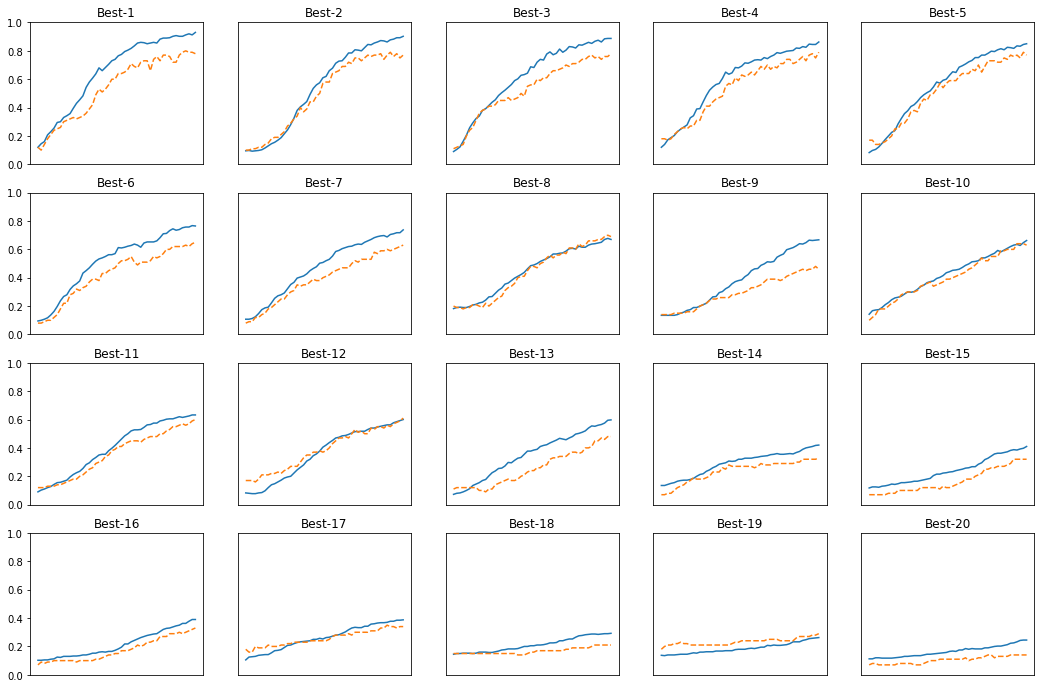

In [ ]:
from dataset.mnist import load_mnist
from common.util import shuffle_dataset

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

x_train=x_train[:500]
t_train=t_train[:500]

validation_rate=0.2
validation_num=int(x_train.shape[0]*validation_rate)
x_train,t_train=shuffle_dataset(x_train,t_train)
x_val=x_train[:validation_num]
t_val=t_train[:validation_num]
x_train=x_train[validation_num:]
t_train=t_train[validation_num:]


def __train(lr,weight_decay,epochs=50):
  network=MultiLayerNet3(input_size=784,hidden_size_list=[100,100,100,100,100,100],
                        output_size=10,weight_decay_lambda=weight_decay)
  trainer=Trainer2(network,x_train,t_train,x_val,t_val,epochs=epochs,mini_batch_size=100,
                   optimizer='SGD',optimizer_param={'lr':lr},verbose=False)
  
  trainer.train()
  
  return trainer.train_acc_list,trainer.test_acc_list

optimization_trial=100
results_val={}
results_train={}

for _ in range(optimization_trial):
  weight_decay=10**np.random.uniform(-8,-4)
  lr=10**np.random.uniform(-6,-2)
  val_acc_list,train_acc_list=__train(lr,weight_decay)
  print('val_acc:'+str(val_acc_list[-1]),' | lr:'+str(lr)+', weight_decay:',str(weight_decay))
  key='lr='+str(lr)+' , weight_decay='+str(weight_decay)
  results_val[key]=val_acc_list
  results_train[key]=train_acc_list

print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i=0

plt.figure(figsize=(18,12),facecolor='w')
for key,val_acc_list in sorted(results_val.items(),key=lambda x: x[1][-1],reverse=True):
  print('Best-'+str(i+1)+'(val_acc:'+str(val_acc_list[-1])+')'+' | '+key)

  plt.subplot(row_num, col_num, i+1)
  plt.title("Best-" + str(i+1))
  plt.ylim(0.0, 1.0)
  if i % 5: plt.yticks([])
  plt.xticks([])
  x = np.arange(len(val_acc_list))
  plt.plot(x, val_acc_list)
  plt.plot(x, results_train[key], "--")
  i += 1

  if i >= graph_draw_num:
    break

plt.show()

val_acc:0.4625  | lr:0.002770363357223559, weight_decay: 1.6828609501471297e-07
val_acc:1.0  | lr:0.07872377151090604, weight_decay: 1.5152628651443084e-06
val_acc:1.0  | lr:0.09599963160161566, weight_decay: 1.0733227584704064e-06
val_acc:0.455  | lr:0.0034343320210516518, weight_decay: 6.288611992976986e-06
val_acc:0.9275  | lr:0.012466531993110019, weight_decay: 1.531375143372869e-06
val_acc:0.9925  | lr:0.018671264602519676, weight_decay: 3.16111370417456e-06
val_acc:0.415  | lr:0.0017284695267311297, weight_decay: 5.307962986505067e-08
val_acc:0.4325  | lr:0.0030444637910236865, weight_decay: 1.5220137012827157e-07
val_acc:0.77  | lr:0.005739547825939969, weight_decay: 7.232661486934046e-06
val_acc:0.9925  | lr:0.021223165833622867, weight_decay: 4.292959346698742e-07
val_acc:0.21  | lr:0.0012587515992031814, weight_decay: 4.899127309353287e-07
val_acc:0.725  | lr:0.0042920236606349355, weight_decay: 3.3186605924473997e-07
val_acc:0.7325  | lr:0.005336127933279529, weight_decay: 5

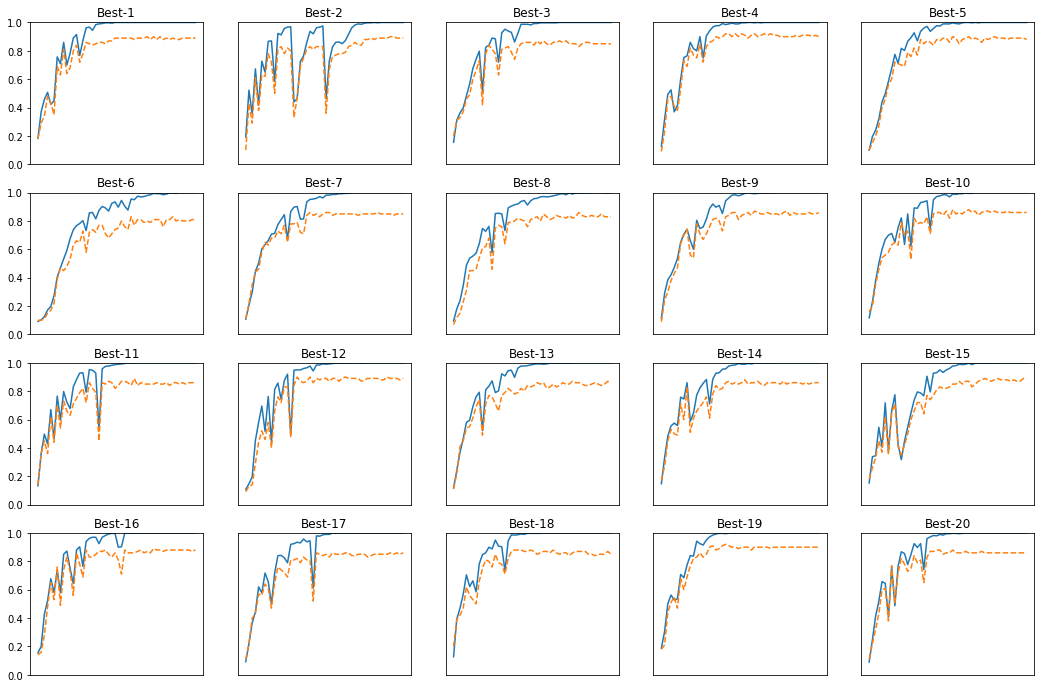

In [ ]:
from dataset.mnist import load_mnist
from common.util import shuffle_dataset

(x_train,t_train),(x_test,t_test)=\
  load_mnist(normalize=True,one_hot_label=True)

x_train=x_train[:500]
t_train=t_train[:500]

validation_rate=0.2
validation_num=int(x_train.shape[0]*validation_rate)
x_train,t_train=shuffle_dataset(x_train,t_train)
x_val=x_train[:validation_num]
t_val=t_train[:validation_num]
x_train=x_train[validation_num:]
t_train=t_train[validation_num:]


def __train(lr,weight_decay,epochs=50):
  network=MultiLayerNet3(input_size=784,hidden_size_list=[100,100,100,100,100,100],
                        output_size=10,weight_decay_lambda=weight_decay)
  trainer=Trainer2(network,x_train,t_train,x_val,t_val,epochs=epochs,mini_batch_size=100,
                   optimizer='SGD',optimizer_param={'lr':lr},verbose=False)
  
  trainer.train()
  
  return trainer.train_acc_list,trainer.test_acc_list

optimization_trial=100
results_val={}
results_train={}

for _ in range(optimization_trial):
  weight_decay=10**np.random.uniform(-8,-4)
  lr=10**np.random.uniform(-3,-1)
  val_acc_list,train_acc_list=__train(lr,weight_decay)
  print('val_acc:'+str(val_acc_list[-1]),' | lr:'+str(lr)+', weight_decay:',str(weight_decay))
  key='lr='+str(lr)+' , weight_decay='+str(weight_decay)
  results_val[key]=val_acc_list
  results_train[key]=train_acc_list

print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i=0

plt.figure(figsize=(18,12),facecolor='w')
for key,val_acc_list in sorted(results_val.items(),key=lambda x: x[1][-1],reverse=True):
  print('Best-'+str(i+1)+'(val_acc:'+str(val_acc_list[-1])+')'+' | '+key)

  plt.subplot(row_num, col_num, i+1)
  plt.title("Best-" + str(i+1))
  plt.ylim(0.0, 1.0)
  if i % 5: plt.yticks([])
  plt.xticks([])
  x = np.arange(len(val_acc_list))
  plt.plot(x, val_acc_list)
  plt.plot(x, results_train[key], "--")
  i += 1

  if i >= graph_draw_num:
    break

plt.show()